# Import libraries & Basic Setup


In [0]:
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt

import PIL
from PIL import Image

import requests
import shutil

In [0]:
def init_random(SEED = 42):
    torch.manual_seed(SEED)
    np.random.seed(SEED)

    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

init_random()

In [0]:
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Custom Layers



In [0]:
normalization_mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = normalization_mean.view(-1, 1, 1)
        self.std = normalization_std.view(-1, 1, 1)

    def forward(self, X):
        return (X - self.mean) / self.std

In [0]:
class ContentLayer(nn.Module):
    def __init__(self, content):
        super(ContentLayer, self).__init__()
        self.loss = 0
        self.content = content.detach()

    def forward(self, X):
        self.loss = F.mse_loss(X, self.content)

        return X

In [0]:
def gram_matrix(X):
    batch, c, h, w = X.size()
    assert batch == 1

    X = X.view(c, h*w)
    G = torch.mm(X, X.t())
    G = G.div(c*h*w)

    return G

class StyleLayer(nn.Module):
    def __init__(self, style_1, style_2):
        super(StyleLayer, self).__init__()
        self.loss = 0
        self.style_1 = gram_matrix(style_1.detach())
        self.style_2 = gram_matrix(style_2.detach())

    def forward(self, X):
        G = gram_matrix(X)
        self.loss_1 = F.mse_loss(G, self.style_1)
        self.loss_2 = F.mse_loss(G, self.style_2)

        return X

# Create Model


In [0]:
# 0..12 convs
default_content_layers = ["conv_5"]
default_style_layers = ["conv_0", "conv_1", "conv_2", "conv_3", "conv_4",]

In [0]:
def create_model(base_model, content_img, style_img_1, style_img_2,
                 content_layers = default_content_layers,
                 style_layers = default_style_layers):
    
    model = nn.Sequential(Normalization())
    content_loss = []
    style_loss = []

    i_layer = -1 # because pre-increment and i prefer to start layers from 0
    for layer in base_model.children():
        if isinstance(layer, nn.Conv2d):
            i_layer += 1
            name = "conv_{}".format(i_layer)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i_layer)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i_layer)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i_layer)
        else:
            raise RuntimeError('Unrecognized layer')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_layer = ContentLayer(target)
            model.add_module("content_{}".format(i_layer), content_layer)
            content_loss.append(content_layer)

        if name in style_layers:
            target_1 = model(style_img_1).detach()
            target_2 = model(style_img_2).detach()
            style_layer = StyleLayer(target_1, target_2)
            model.add_module("style_{}".format(i_layer), style_layer)
            style_loss.append(style_layer)

    return model, content_loss, style_loss

In [10]:
base_model = models.vgg16(pretrained=True).features.to(device)
for param in base_model.parameters():
    param.requires_grad = False
base_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# NST function





In [0]:
def StyleTransfer(base_model, Content, Style_1, Style_2, nb_epoch = 500, alpha = 1, beta = 500000, gamma = 500000, log_step = 50):
    Input = Content.clone()
    Input.requires_grad = True

    optimizer = torch.optim.LBFGS([Input])
    Model, content_loss, style_loss = create_model(base_model, Content, Style_1, Style_2)

    t = [0]
    while t[0] <= nb_epoch:
        def closure():
            Input.data.clamp_(0, 1)
            optimizer.zero_grad()

            Model(Input)

            L_content = 0
            for layer in content_loss:
                L_content += layer.loss
            
            L_style_1, L_style_2 = 0, 0
            for layer in style_loss:
                L_style_1 += layer.loss_1
                L_style_2 += layer.loss_2

            
            L_content *= alpha
            L_style_1 *= beta
            L_style_2 *= gamma

            loss = L_content + L_style_1 + L_style_2
            loss.backward()

            t[0] += 1
            if t[0] % log_step == 0:
                print("Epoch {} (C/S1/S2):".format(t), L_content.item(), L_style_1.item(), L_style_2.item())
                print()

            return L_content + L_style_1 + L_style_2

        optimizer.step(closure)

    Input.data.clamp_(0, 1)
    return Input

# Image functions

In [0]:
img_size = 512

def load_image(filename):
    img = Image.open(filename)

    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ])

    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device, torch.float)

    return img

In [0]:
def download_image(image_url, filename):
    r = requests.get(image_url, stream = True)

    if r.status_code == 200:
        r.raw.decode_content = True
        with open(filename,'wb') as f:
            shutil.copyfileobj(r.raw, f)
        print('Image sucessfully Downloaded: ', filename)
    else:
        raise RuntimeError("Failed to load image")


    img = load_image(filename)
    return img

In [0]:
def imshow(img, plt_name = None):
    img = transforms.ToPILImage()(img.clone().squeeze(0).cpu())
    if plt_name != None:
        plt.title(plt_name)
    plt.imshow(img)
    plt.show()

# Examples

Image sucessfully Downloaded:  Content
Image sucessfully Downloaded:  Style_1
Image sucessfully Downloaded:  Style_2



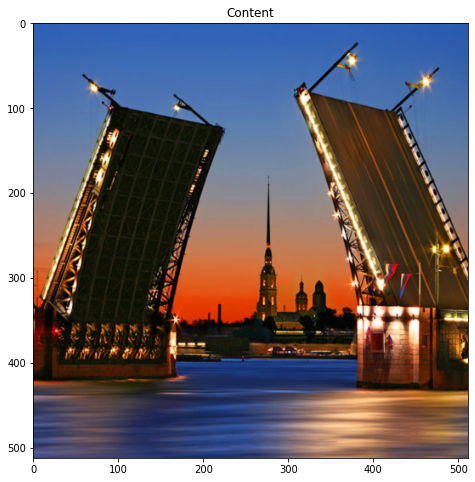

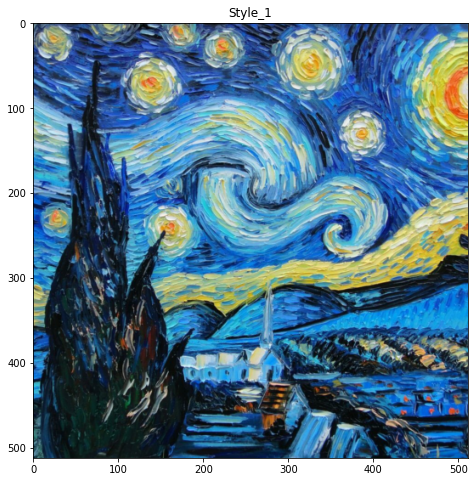

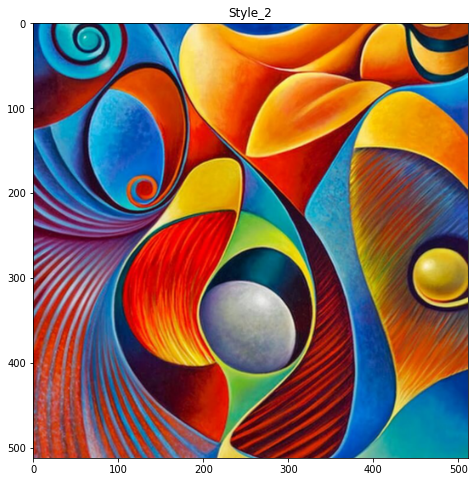

Epoch [100] (C/S1/S2): 85.25556945800781 12539.626953125 13092.2490234375

Epoch [200] (C/S1/S2): 78.9451904296875 12664.9736328125 12773.0537109375

Epoch [300] (C/S1/S2): 66.7333984375 12670.7490234375 12726.8408203125

Epoch [400] (C/S1/S2): 59.13673782348633 12659.46484375 12728.25390625

Epoch [500] (C/S1/S2): 54.63215637207031 12653.2763671875 12730.4345703125



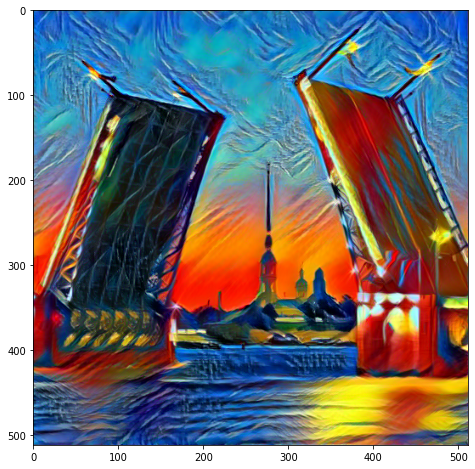

In [15]:
# Params
Content = download_image("https://avatars.mds.yandex.net/get-pdb/25978/ae286663-0fbe-4c49-812f-0ceebf95e6d9/s1200?webp=false", "Content") 
Style_1 = download_image("https://avatars.mds.yandex.net/get-zen_doc/22526/pub_5c5d72605bd0cb00ac3df143_5c5d753d59bfd800b0ce668f/scale_1200", "Style_1")
Style_2 = download_image("https://avatars.mds.yandex.net/get-pdb/2728863/e420769a-53f2-41f9-82d7-6520b185e9c1/s1200?webp=false", "Style_2")

alpha = 1       # Weight of Content Loss
beta =  2000000 # Weight of Style_1 Loss
gamma = 2000000 # Weight of Style_2 Loss

# Run NST
print()
imshow(Content, "Content")
imshow(Style_1, "Style_1")
imshow(Style_2, "Style_2")

init_random()
res = StyleTransfer(
    base_model, Content, Style_1, Style_2,
    nb_epoch = 500, log_step = 100,
    alpha = alpha, beta = beta, gamma = gamma,
)

imshow(res)

Image sucessfully Downloaded:  Content
Image sucessfully Downloaded:  Style_1
Image sucessfully Downloaded:  Style_2



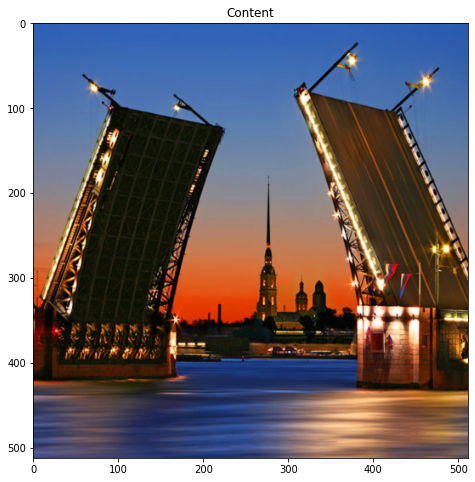

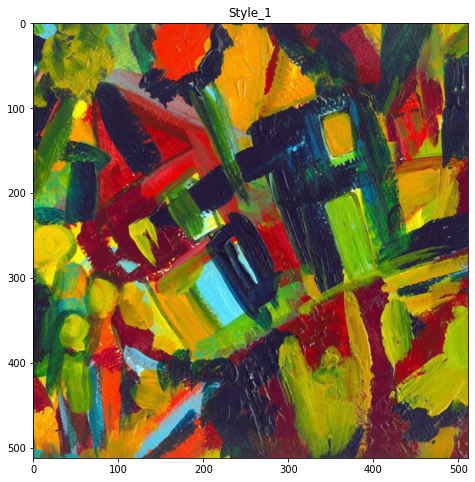

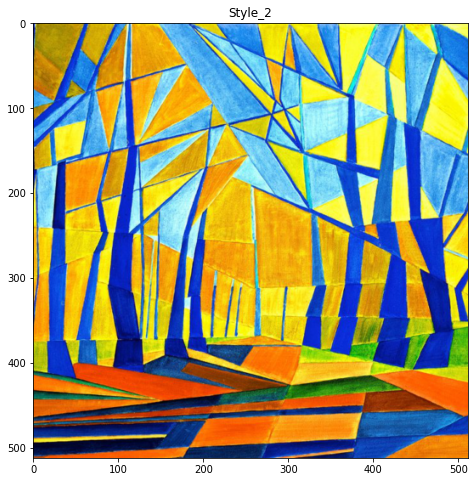

Epoch [100] (C/S1/S2): 112.14134979248047 10905.779296875 43081.43359375

Epoch [200] (C/S1/S2): 100.58027648925781 10711.8818359375 42923.99609375

Epoch [300] (C/S1/S2): 84.88162994384766 10698.1796875 42889.2265625

Epoch [400] (C/S1/S2): 75.54869079589844 10682.916015625 42893.90234375

Epoch [500] (C/S1/S2): 70.22067260742188 10679.0078125 42894.234375



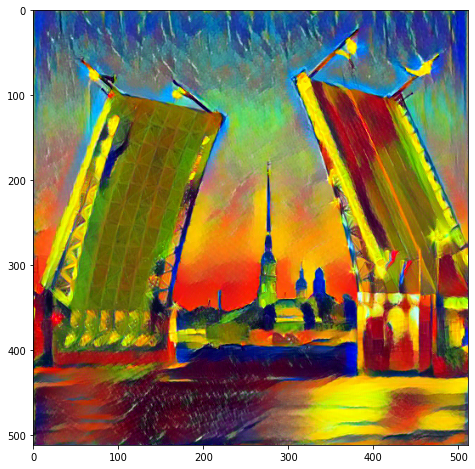

In [16]:
# Params
Content = download_image("https://avatars.mds.yandex.net/get-pdb/25978/ae286663-0fbe-4c49-812f-0ceebf95e6d9/s1200?webp=false", "Content") 
Style_1 = download_image("https://cs6.livemaster.ru/storage/ec/b6/81fa6072d01a41259f18e1cda7oc.jpg", "Style_1")
Style_2 = download_image("https://avatars.mds.yandex.net/get-pdb/1381440/e49a9434-d180-4ada-8182-b539603b9450/s1200?webp=false", "Style_2")

alpha = 1      # Weight of Content Loss
beta =  2000000  # Weight of Style_1 Loss
gamma = 500000 # Weight of Style_2 Loss

# Run NST
print()
imshow(Content, "Content")
imshow(Style_1, "Style_1")
imshow(Style_2, "Style_2")

init_random()
res = StyleTransfer(
    base_model, Content, Style_1, Style_2,
    nb_epoch = 500, log_step = 100,
    alpha = alpha, beta = beta, gamma = gamma,
)

imshow(res)